# Bike-Share trip analysis

In this project we examine the last 12 month publicly available data on Divvy Bikeshare trips in Chicago. The business question we have in mind is what are the main differences of how the casual users use Divvy bike compared to paying members. After this analysis we intend to produce business recommendations aimed at converting casual users to paying subscribers. 

The data is available publicly at: https://divvy-tripdata.s3.amazonaws.com/index.html

It has some major limitations: there is no way to group the trips by user, since the data is completely anonimized. There is also no demographic data, which would have allowed us to see if the trip-taker lives in the area or is visiting short term. 

In [4]:
import os
import pandas as pd
from haversine import haversine, Unit
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from cartopy.io.img_tiles import OSM
from sklearn.cluster import KMeans,OPTICS
import csv
import zipfile
import numpy as np

extract_path='data/'
zip_dir='data/originals/'   



## Data Preparation and Cleaning
Files are extracted for .zip files in data/originals folder, then processed, and combined into a single master .csv file, which is then split into members and casual users data.

### Cleaning 
Time columns are converted to pandas datetime datatype.

    to-do:
    identify cases where start date is after end date and remove those cases
    identify cases where the ride duration is >1 day. these cases a likely incorrectly logged or are extreme outliers, so remove them
    remove "instant trips" (<30 seconds), these seem to be mistaken unlocks where bikes are returned immediately


### Processing
- The original data comes with GPS coordinates of start and end of each trip. For our basic analysis we make use of these by using them to calculate the trip distance. After the calculation the coordinate columns are dropped.
- Ride length is calculated as timedelta
- Day of the week is determined from the start date
- Speed is calculated from the distance and trip duration

    to-do:
    make a time-of-day distribution

In [5]:
def calc_distance(start_lat,start_lng,end_lat,end_lng):
    start=(start_lat,start_lng)
    end=(end_lat,end_lng)
    dist=haversine(start,end,unit=Unit.MILES)
    return dist

def process(df):
    df['started_at']=pd.to_datetime(df['started_at'])
    df['ended_at']=pd.to_datetime(df['ended_at'])
    df['ride_length']=df['ended_at']-df['started_at']
    df['day_of_week']=df['started_at'].dt.dayofweek
    df['distance']=df.apply(lambda row: calc_distance(row["start_lat"], row["start_lng"], row["end_lat"], row["end_lng"]), axis=1)
    df['distance']=df['distance'].round(2)
    df['speed']=df['distance']/df['ride_length'].dt.total_seconds()*3600
    df['speed']=df['speed'].round(2)
    df=df.drop(columns=['start_lat','start_lng','end_lat','end_lng'])
    return df

if not os.path.exists('combined.csv'):
    for zip_filename in os.listdir(zip_dir):
        if zip_filename.endswith('.zip'):
            with zipfile.ZipFile(os.path.join(zip_dir,zip_filename),'r') as zip_file:
                zip_file.extractall(extract_path)
    
    for filename in filenames:
        chunks=pd.read_csv(os.path.join(path,filename),chunksize=1000)
        df=pd.concat(chunks,ignore_index=True)
        df=process(df)
        df.to_csv(path+'/processed/'+filename+'_processed.csv')


    csv_files = os.listdir(path+"/processed")
    with open(path+'/processed/'+csv_files[0],'r')as csvfile:
        csvreader=csv.reader(csvfile)
        with open('combined.csv','w')as outfile:
            csvwriter=csv.writer(outfile)
            csvwriter.writerow(next(csvreader))
            for csv_file in csv_files[0:]:
                with open(path+'/processed/'+csv_file,'r')as infile:
                    csvreader=csv.reader(infile)
                    csvwriter.writerow(next(csvreader))
                    for row in csvreader:
                        csvwriter.writerow(row)
    df=pd.read_csv('combined.csv')

    df[df['member_casual']=='member'].to_csv('members.csv')
    df[df['member_casual']=='casual'].to_csv('casuals.csv')
    del df

## Analysis

Working with Members and Casual riders data separately we perform the following calculations:

- Count total trips
- Calculate mean distance(miles) and duration(minutes)
- Calculate proportion of electric bike users
- Create distributions of bike usage by day of the week
- Create distributions of bike usage by month

In [58]:
df_members=pd.read_csv('members.csv')

df_members['started_at'] = pd.to_datetime(df_members['started_at'], errors='coerce')
df_members['ended_at'] = pd.to_datetime(df_members['ended_at'], errors='coerce')
df_members['ride_length'] = pd.to_timedelta(df_members['ride_length'], errors='coerce')

num_trips_members=df_members['ride_id'].count()
avg_distance_members=df_members['distance'].mean()
avg_ride_length_members=df_members['ride_length'].mean()
members_duration_dist=df_members['ride_length'].dt.total_seconds()/60
members_distance_dist=df_members['distance']

electric_members=len(df_members[df_members['rideable_type']=='electric_bike'])
electric_members_proportion=electric_members/np.count_nonzero(df_members['rideable_type'])

members_days_of_week_dist=[]
for day in range (7):
    members_days_of_week_dist.append(len(df_members[df_members['day_of_week']==day]))
    #sum=np.sum(num_trips_members)
    #members_days_of_week_dist=[e/sum for e in members_days_of_week_dist]
#plt.bar(x=['0','1','2','3','4','5','6'],height=members_days_of_week_dist)
members_month_dist=[]
for month in range (1,13):
    members_month_dist.append(len(df_members[df_members['started_at'].dt.month==month]))
    #sum=np.sum(members_month_dist)
    #members_month_dist=[e/sum for e in members_month_dist]
#print(num_trips_members,avg_distance_members,avg_ride_length_members)
#print(members_days_of_week_dist/np.sum(members_days_of_week_dist))
#print(members_month_dist/np.sum(members_month_dist))
#print(df_members['ride_length'].describe())
del df_members

count                      3402661
mean     0 days 00:12:42.663126006
std      0 days 00:29:06.588539980
min              -8 days +19:26:39
25%                0 days 00:05:06
50%                0 days 00:08:50
75%                0 days 00:15:18
max                1 days 01:59:54
Name: ride_length, dtype: object


In [59]:
df_casuals=pd.read_csv('casuals.csv')

df_casuals['started_at'] = pd.to_datetime(df_casuals['started_at'], errors='coerce')
df_casuals['ended_at'] = pd.to_datetime(df_casuals['ended_at'], errors='coerce')
df_casuals['ride_length'] = pd.to_timedelta(df_casuals['ride_length'], errors='coerce')

num_trips_casuals=df_casuals['ride_id'].count()
avg_distance_casuals=df_casuals['distance'].mean()
avg_ride_length_casuals=df_casuals['ride_length'].mean()

casuals_duration_dist=df_casuals['ride_length'].dt.total_seconds()/60
casuals_distance_dist=df_casuals['distance']

electric_casuals=len(df_casuals[df_casuals['rideable_type']=='electric_bike'])
electric_casuals_proportion=electric_casuals/np.count_nonzero(df_casuals['rideable_type'])


casuals_days_of_week_dist=[]
for day in range (7):
    casuals_days_of_week_dist.append(len(df_casuals[df_casuals['day_of_week']==day]))
#plt.bar(x=['0','1','2','3','4','5','6'],height=members_days_of_week_dist)
casuals_month_dist=[]
for month in range (1,13):
    casuals_month_dist.append(len(df_casuals[df_casuals['started_at'].dt.month==month]))
    
#print(num_trips_casuals,avg_distance_casuals,avg_ride_length_casuals)
#print(casuals_days_of_week_dist/np.sum(casuals_days_of_week_dist))
#print(casuals_month_dist/np.sum(casuals_days_of_week_dist))
#print(df_casuals['ride_length'].describe())
del df_casuals 

count                      2353033
mean     0 days 00:29:10.206343472
std      0 days 04:30:49.654091613
min              -1 days +21:42:35
25%                0 days 00:07:27
50%                0 days 00:13:10
75%                0 days 00:24:19
max               28 days 17:47:15
Name: ride_length, dtype: object


### Summary table

In [8]:
summary_columns=['user_type','number of trips','average trip distance(miles)','average trip duration(minutes)','electric bike proportion']
casuals_summary=['casual users',num_trips_casuals,avg_distance_casuals,avg_ride_length_casuals,electric_casuals_proportion]
members_summary=['members',num_trips_members,avg_distance_members,avg_ride_length_members,electric_members_proportion]
summary=[casuals_summary,members_summary]
summary_df=pd.DataFrame(summary,columns=summary_columns)
summary_df.round(2)

,user_type,number of trips,average trip distance(miles),average trip duration(minutes),electric bike proportion
0,casual users,2353033,1.36,0 days 00:29:10.206343472,0.54
1,members,3402661,1.30,0 days 00:12:42.663126006,0.49


### Bike usage by day of the week

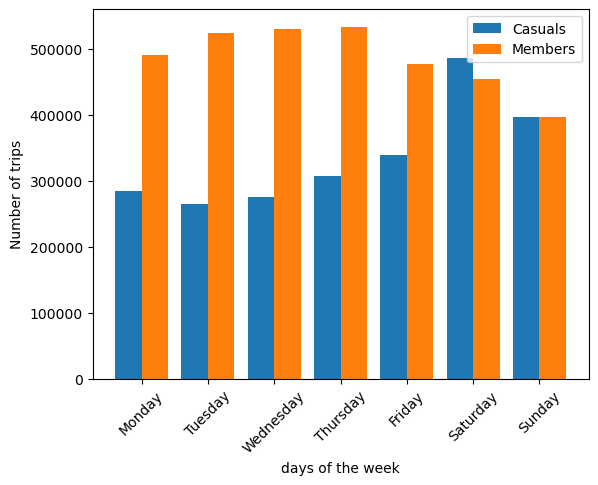

In [9]:
X = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, casuals_days_of_week_dist, 0.4, label = 'Casuals')
plt.bar(X_axis + 0.2, members_days_of_week_dist, 0.4, label = 'Members')
#plt.bar(X_axis - 0.2, casuals_days_of_week_dist/np.sum(casuals_days_of_week_dist), 0.4, label = 'Casuals')
#plt.bar(X_axis + 0.2, members_days_of_week_dist/np.sum(members_days_of_week_dist), 0.4, label = 'Members')
plt.xticks(X_axis, X,rotation = 45)
plt.xlabel("Day of the week")
plt.ylabel("Number of trips")
#plt.title("Number of tri in each group")
plt.legend()
plt.show()

### Bike usage by month

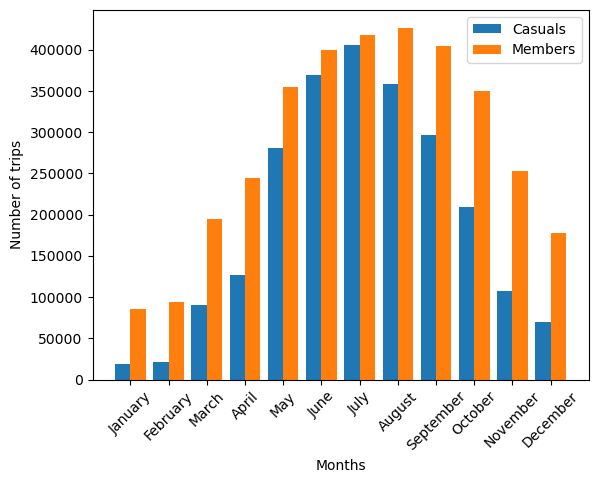

In [10]:
X = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, casuals_month_dist, 0.4, label = 'Casuals')
plt.bar(X_axis + 0.2, members_month_dist, 0.4, label = 'Members')
#plt.bar(X_axis - 0.2, casuals_month_dist/np.sum(casuals_month_dist), 0.4, label = 'Casuals')
#plt.bar(X_axis + 0.2, members_month_dist/np.sum(members_month_dist), 0.4, label = 'Members')

plt.xticks(X_axis, X, rotation=45)
plt.xlabel("Months")
plt.ylabel("Number of trips")
#plt.title("Number of tri in each group")
plt.legend()
plt.show()

### Bike trip durations

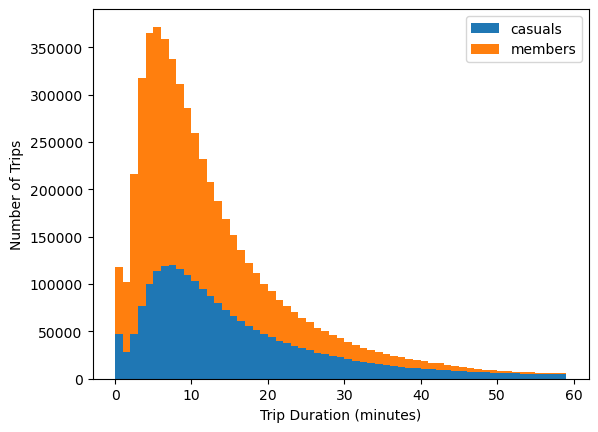

In [60]:
bins=np.arange(0,60,1)
#print (len(bins))
durations = pd.DataFrame({'casuals': casuals_duration_dist, 'members': members_duration_dist})
hist=durations.plot.hist(bins=bins,stacked=True)
hist.set_xlabel('Trip Duration (minutes)')
hist.set_ylabel('Number of Trips')
hist.ticklabel_format(style='plain',useOffset=False)


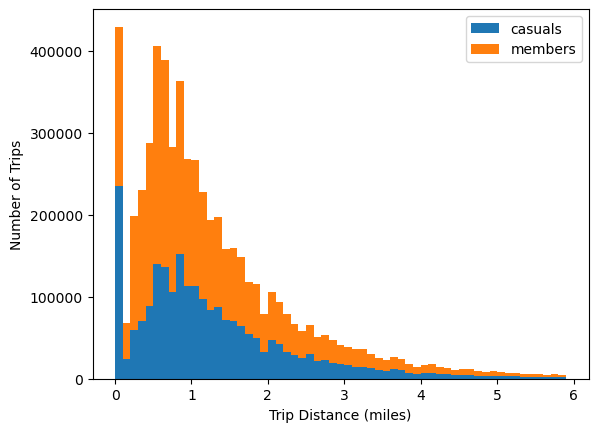

In [61]:
bins=np.arange(0, 6, 0.1)
#print (len(bins))
durations = pd.DataFrame({'casuals': casuals_distance_dist, 'members': members_distance_dist})
#hist=durations.plot.hist(bins=[0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5],stacked=True)
hist=durations.plot.hist(bins=bins,stacked=True)

hist.set_xlabel('Trip Distance (miles)')
hist.set_ylabel('Number of Trips')

hist.ticklabel_format(style='plain',useOffset=False)

In [41]:
np.arange(0, 10.1, 0.1)



array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])

## Analysis interpretation

With no clear difference between members and casual users in terms of trip duration or distance, we are still able to focus on an important bike usage differences:

- Casual users strongly prefer warmer months and weekends for the trips compared to paying members
- Paying members show much stronged weekday usage as well as continued usage trough even winter months, likely indicating commuting behavior


## Putting the data to use

Based on our analysis of user trips, we believe that the following business actions are warranter:
- Ramping up marketing of the benefit membership to summer month Chicago visitors. 
- Partnering with local events that encourage tourists to use the bikeshare service
- Introducing a weekly subscription model for visitors who may not be staying for multiple months

By targeting these specific groups of tourists and offering flexible subscription options, we believe that Divvy Bikeshare can attract more casual users to sign up for the paid membership.



